In [1]:
! if [ ! -e rmf_tool ]; then git clone https://github.com/ngast/rmf_tool.git; fi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import rmf_tool.src.heterogeneous_rmf_tool as hrmf

%matplotlib notebook

## Heterogeneous SIS Model Setup for HetPP class (heterogeneus pairwise transitions)

SIS model with N item and d = 2 dimensions (susceptible and infected). 

Transitions are defined specifying the tensors 'unilateral_transitions' and 'pairwise_transitions'. 

Below, an SIS model which allows infections only through a neighborhood is initialized. The range of the neighborhood is specified by the value 'neighbor_range'.

In [108]:
N = 40
d = 2

S, I = 0, 1
model = hrmf.HetPP()

# initialization of rate tensors
unilateral_transitions, pairwise_transitions = np.zeros((N, d, d)), np.zeros((N, N, d, d, d, d)) 

# set unilateral transitions
unilateral_transitions[:, S, I] = np.ones((N))
# unilateral_transitions[:, I, S] = np.ones((N))

# specify neighborhood range
neighborhood_range = 1

# set pairwise transition rates
for i in range(N):
    if (i - neighborhood_range) < 0:
        pairwise_transitions[i, 0:i + neighborhood_range , S, I, I, I] = (1/N) * np.ones(pairwise_transitions[i, 0:i + neighborhood_range , S, I, I, I].shape)
    else:
#         pairwise_transitions[i, i-neighborhood_range:i+neighborhood_range, S, I, I, I] = (1/N) * np.ones(pairwise_transitions[i, i-neighborhood_range:i+neighborhood_range, S, I, I, I].shape)
        pairwise_transitions[i, i-neighborhood_range:i+neighborhood_range, S, I, I, I] = (1/N) * np.random.random(size=pairwise_transitions[i, i-neighborhood_range:i+neighborhood_range, S, I, I, I].shape)

# add rate tensors to the model and set initial state of the system
model.add_rate_tensors(unilateral_transitions, pairwise_transitions)
model.set_initial_state(np.ones((N,d))*np.array([1,0]))


### Mean field (X_transient) and refinement (V_transient) calculation

In [109]:
T_transient, X_transient, V_transient, XVW_transient = model.meanFieldExpansionTransient(order=1, time=3)

### Sample mean calculation

In [34]:
# calculate the sample mean of 200 trajectories


samples = 200

# to ensure reproducibility seeds can be set for the methods sampleMean, sampleMeanVariance, simulate
# seeds = np.arange(0,samples)

T_mean, X_mean, Err = model.sampleMeanVariance(time=2, samples=samples, seeds=None)

Mean Calculation; Nr. Simulations done:
10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  
Variance; Nr. Simulations done:
10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  

In [6]:
def plot_var_single(T, X, Var, i, s, ax=None):
    if ax is None:
        plt.fill_between(T, X[:, i, s] + Var[:, i, s], X[:, i, s] - Var[:, i, s], color="cornflowerblue", alpha=.3)
    else:
        ax.fill_between(T, X[:, i, s] + Var[:, i, s], X[:, i, s] - Var[:, i, s], color="cornflowerblue", alpha=.3)
    
def plot_both_states(T, X, Var, i):
    f, subplot_list = plt.subplots(1, 2, sharey=True)
    subplot_list = subplot_list.flatten()
    f.set_figwidth(16)
    f.set_figheight(5)
    
    
    for s, ax in enumerate(subplot_list):
        ax.plot(T_mean, X_mean[:,i,s], label="Sample Mean")
        plot_var_single(T_mean, X_mean, sample_Var, i, s, ax)

        ax.plot(T_transient, X_transient[:,i,s],'--', label="Mean field approximation")
        ax.plot(T_transient, (X_transient + V_transient)[:,i,s], label="Refined mf approximation")
        
        if s == 0:
            state = 'S'
        else:
            state = 'I'
        
        ax.title.set_text('Item {} State {}'.format(i, state))
        ax.set_xlabel('Time $t$', size='x-large')
            
        ax.set_ylabel('State $\mathbb{E}[Z_{(' + str(i) + ',' + str(state) + ')}(t)]$', size='x-large')
        ax.legend()


### Expected state of item i against its (refined) mean field approximation

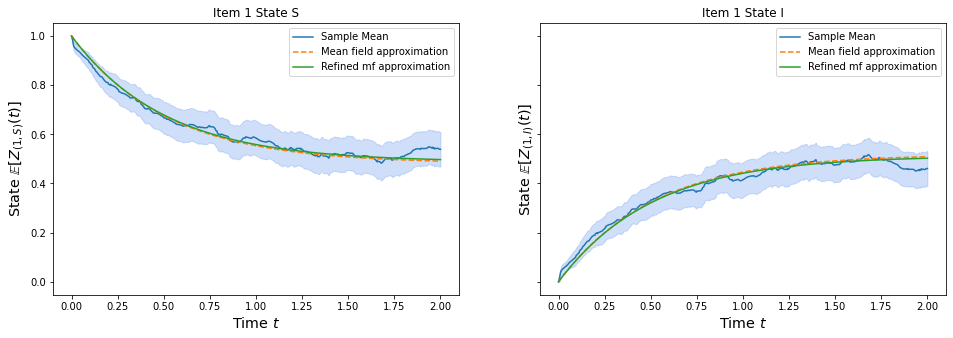

In [7]:
%matplotlib inline

sample_Var = 2* np.sqrt(Err)/np.sqrt(samples)

i = 1

plot_both_states(T_mean, X_mean, sample_Var, i)

## Comparison to homogeneous model

In [95]:
model_hom = hrmf.HetPP()

# initialization of rate tensors
A_hom, B_hom = np.zeros((N, d, d)), np.zeros((N, N, d, d, d, d)) 

# set unilateral transitions
# A[:, S, I] = np.ones((N))
A_hom[:, S, I] = np.ones((N))
# introduce heterogeneity
np.random.seed(1)
# A_hom[:, I, S] = np.ones((N))

# set pairwise transition rates
B_hom[:, :, S, I, I, I] = (1/N) * np.ones((N, N))


# add rate tensor to the model and set initial state of the system
model_hom.add_rate_tensors(A_hom, B_hom)
model_hom.set_initial_state(np.ones((N,d)) * np.array([1,0]))

In [100]:
T_transient_hom, X_transient_hom, V_transient_hom, XVW_transient_hom = model_hom.meanFieldExpansionTransient(order=1, time=3)

In [101]:
def plot_camparison_mf(T1, X1, T2, X2):
    f, subplot_list = plt.subplots(1, 2, sharey=True)
    subplot_list = subplot_list.flatten()
    f.set_figwidth(16)
    f.set_figheight(5)
    
    
    for s, ax in enumerate(subplot_list):
        ax.plot(T1, X1[:, s], label="MF hom")

        ax.plot(T2, X2[:, s],'--', label="MF het")
#         ax.plot(T_transient, (X_transient + V_transient)[:,i,s], label="Refined mf approximation")
        
        if s == 0:
            state = 'S'
        else:
            state = 'I'
        
        ax.title.set_text('Item {} State {}'.format(i, state))
        ax.set_xlabel('Time $t$', size='x-large')
            
        ax.set_ylabel('State $\mathbb{E}[Z_{(' + str(i) + ',' + str(state) + ')}(t)]$', size='x-large')
        ax.legend()


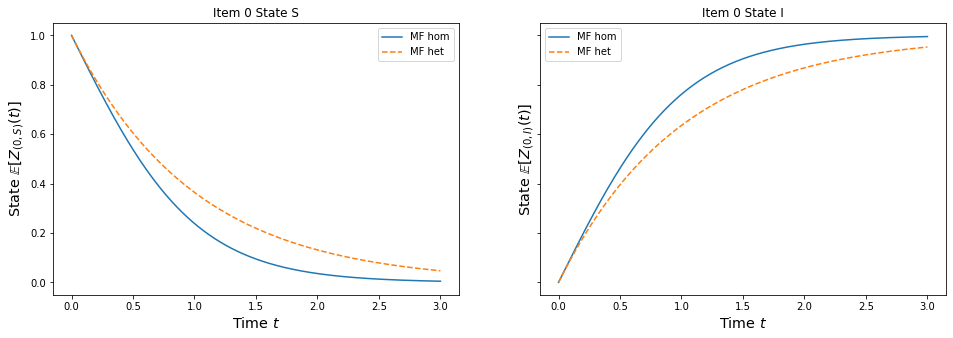

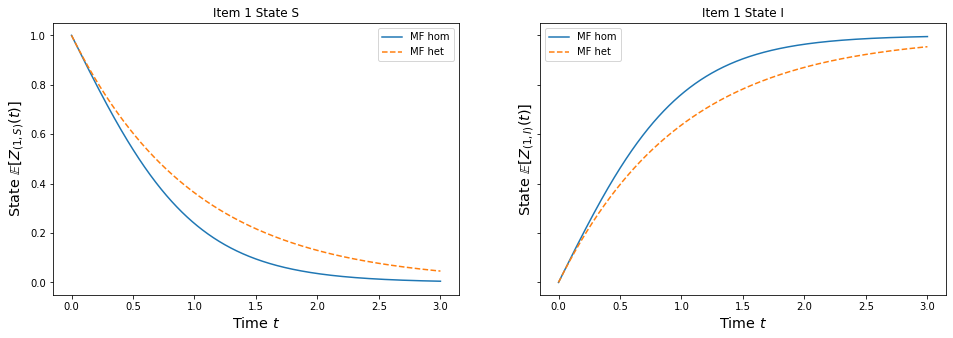

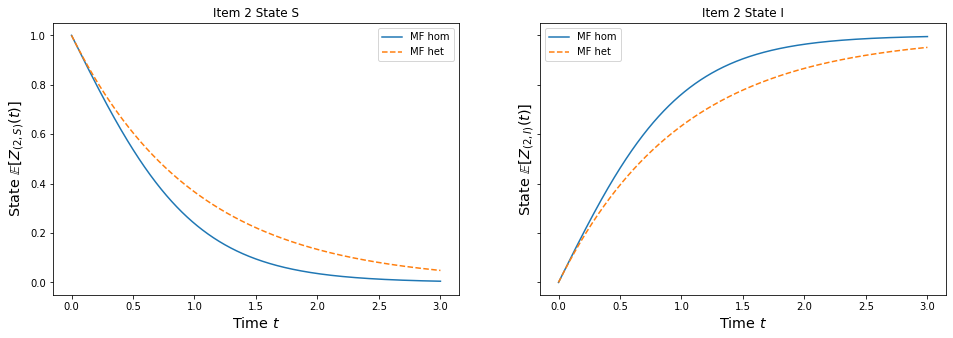

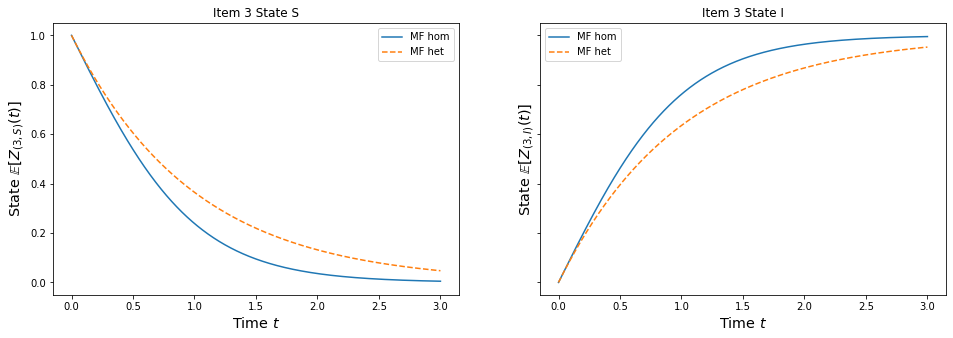

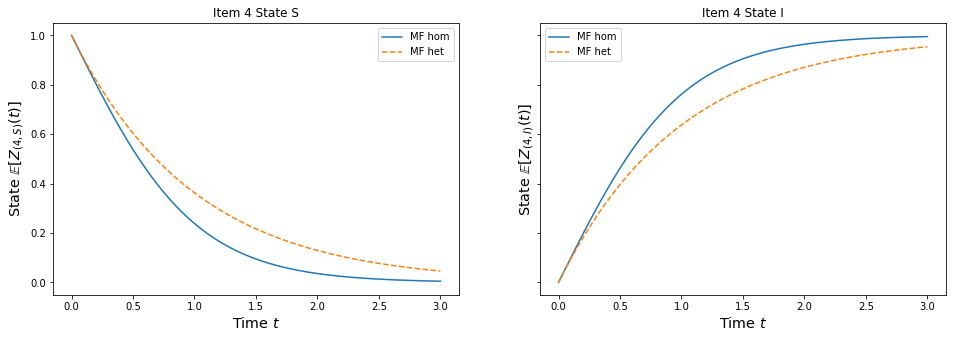

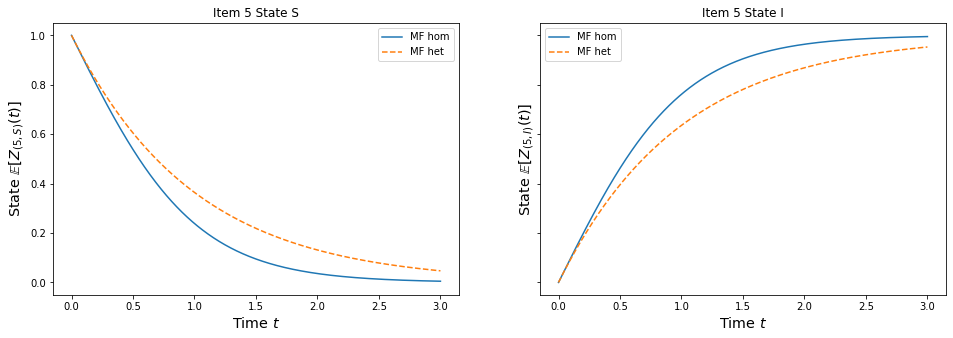

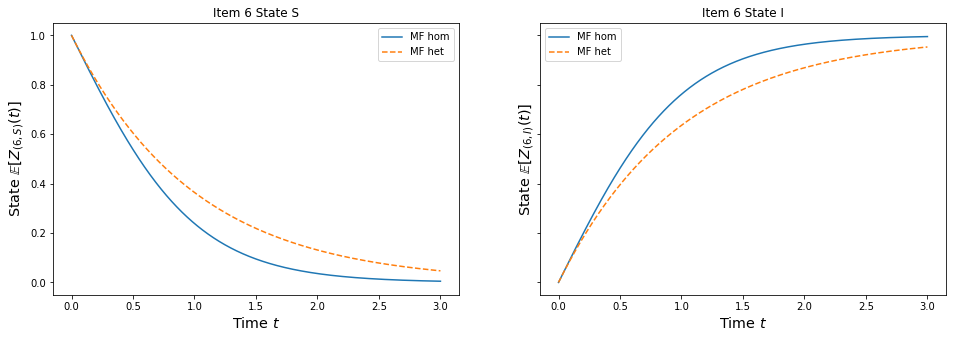

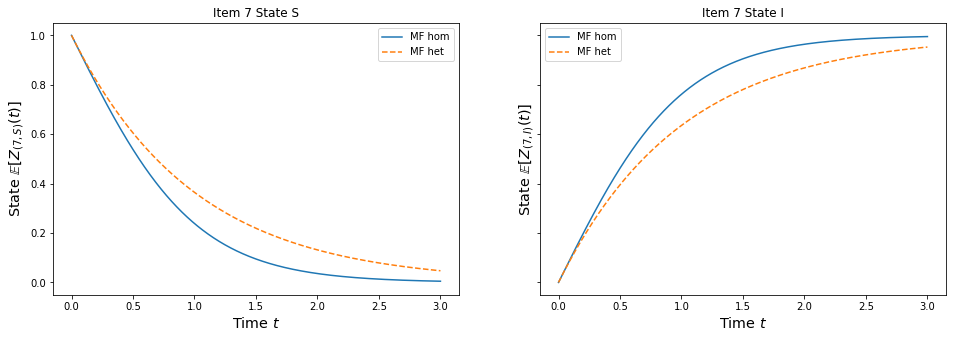

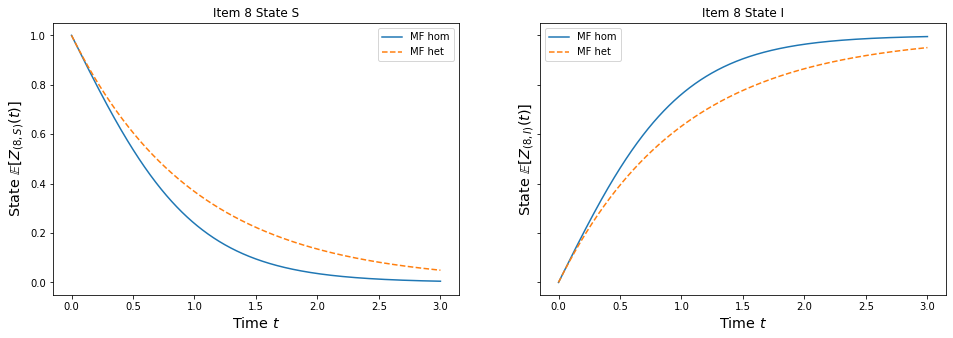

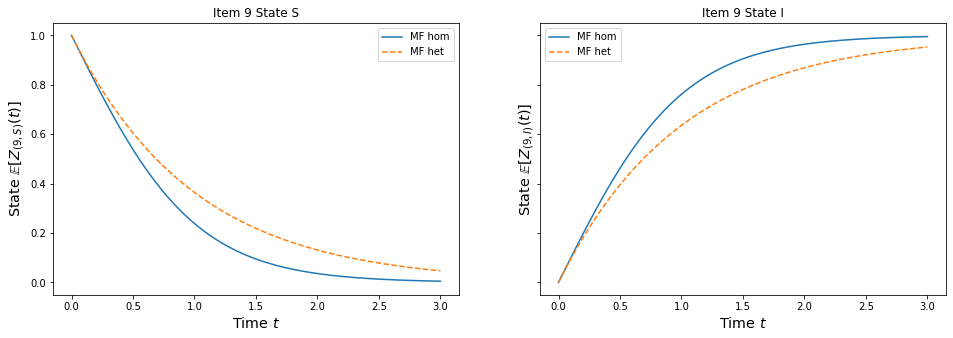

In [110]:
for i in range(10):
    plot_camparison_mf(T_transient_hom, X_transient_hom[:,i,:], T_transient, X_transient[:,i,:])


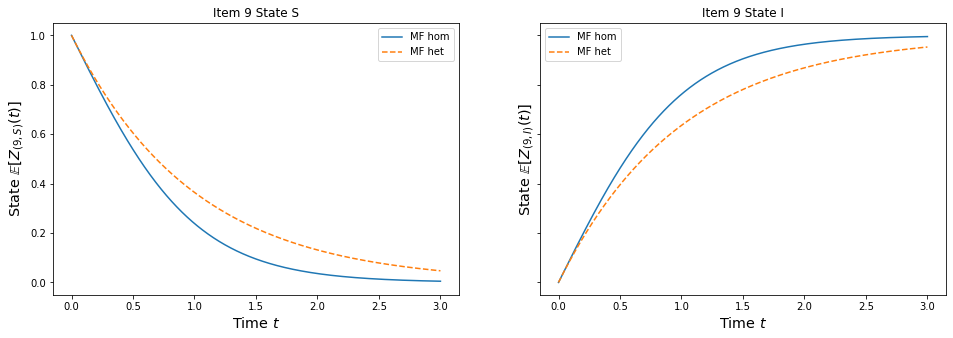

In [111]:
plot_camparison_mf(T_transient_hom, np.sum(X_transient_hom, axis=1)/N, T_transient, np.sum(X_transient, axis=1)/N)
